# Learning Gaussian Process regression parameters using mini-batch stochastic gradient descent
> How to learn the parameters of a GP

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

### Defining log-likelihood

In our previous post we had mentioned (for the **noiseless case**):

Given train data
$$
D=\left(x_{i}, y_{i}\right), i=1: N
$$
Given a test set $X_{*}$ of size $N_{*} \times d$ containing $N_{*}$ points in $\mathbb{R}^{d},$ we want to predict function outputs $y_{*}$
We can write:
$$
\left(\begin{array}{l}
y \\
y_{*}
\end{array}\right) \sim \mathcal{N}\left(\left(\begin{array}{l}
\mu \\
\mu_{*}
\end{array}\right),\left(\begin{array}{cc}
K & K_{*} \\
K_{*}^{T} & K_{* *}
\end{array}\right)\right)
$$
where
$$
\begin{aligned}
K &=\operatorname{Ker}(X, X) \in \mathbb{R}^{N \times N} \\
K_{*} &=\operatorname{Ker}\left(X, X_{*}\right) \in \mathbb{R}^{N \times N} \\
K_{* *} &=\operatorname{Ker}\left(X_{*}, X_{*}\right) \in \mathbb{R}^{N_{*} \times N_{*}}
\end{aligned}
$$

Thus, from the property of conditioning of multivariate Gaussian, we know that:

$$y \sim \mathcal{N}_N(\mu, K)$$

We will assume $\mu$ to be zero. Thus, we have for the train data, the following expression:

$$y \sim \mathcal{N}_N(0, K)$$

For the **noisy case**, we have:

$$y \sim \mathcal{N}_N(0, K + \sigma_{noise}^2\mathcal{I}_N)$$

From this expression, we can write the log-likelihood of data computed over the kernel parameters $\theta$ as:

$$\mathcal{LL}(\theta) = \log(\frac{\exp((-1/2)(y-0)^T (K+\sigma_{noise}^2\mathcal{I}_N)^{-1}(y-0))}{(2\pi)^{N/2}|(K+\sigma_{noise}^2\mathcal{I}_N)|^{1/2}})$$

Thus, we can write:

$$\mathcal{LL}(\theta) =\log P(\mathbf{y} | X, \theta)=-\frac{1}{2} \mathbf{y}^{\top} M^{-1} \mathbf{y}-\frac{1}{2} \log |M|-\frac{N}{2} \log 2 \pi$$

where $$M = K + \sigma_{noise}^2\mathcal{I}_N$$

### Imports

As before, we will be using the excellent Autograd library for automatically computing the gradient of an objective function with respect to the parameters. We will also be using GPy for verifying our calculations.

Let us start with some basic imports.

In [1]:
import autograd.numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import GPy

### Defining our RBF kernel



The definition of the (1-dimensional) RBF kernel has a Gaussian-form, defined as:

$$
    \kappa_\mathrm{rbf}(x_1,x_2) = \sigma^2\exp\left(-\frac{(x_1-x_2)^2}{2\mathscr{l}^2}\right)
$$


In [2]:
def rbf(x1, x2, sigma, l):
    return (sigma**2)*(np.exp(-(x1-x2)**2/(2*(l**2))))    

### Defining GPy's RBF kernel

In [3]:
# Create a 1-D RBF kernel with default parameters
k = GPy.kern.RBF(1)
# Preview the kernel's parameters
k

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


### Matching our RBF kernel with GPy's kernel

In [4]:
rbf(1, 0, 1, 1)==k.K(np.array([[1]]), np.array([[0]])).flatten()

array([ True])

Looks good. Our function is matching GPy's kernel.

### GP Regresion

#### Creating a data set

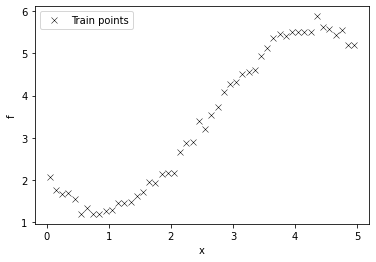

In [5]:
# lambda function, call f(x) to generate data
f = lambda x: 0.4*x**2 - 0.15*x**3 + 0.5*x**2 - 0.002*x**5 + 0.0002*x**6 +0.5*(x-2)**2
n = 50
np.random.seed(0)
X = np.linspace(0.05, 4.95, n)[:,None]
Y = f(X) + np.random.normal(0., 0.1, (n,1)) # note that np.random.normal takes mean and s.d. (not variance), 0.1^2 = 0.01
plt.plot(X, Y, "kx", mew=0.5, label='Train points')
plt.xlabel("x"), plt.ylabel("f")
plt.legend();

### Function to compute negative log likelihood

Based on our above mentioned theory, we can now write the NLL function as follows

In [6]:
def nll(X, Y, sigma, l, noise_std):
    n = X.shape[0]
    cov = rbf(X, X.T, sigma, l) + (noise_std**2)*np.eye(X.shape[0])
    nll_ar =  0.5*(Y.T@np.linalg.inv(cov)@Y) + 0.5*n*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(cov)) 
    return nll_ar[0,0]

### Comparing the NLL from our method with the NLL from GPy

We will now compare the NLL from our method with GPy for a fixed set of parameters

In [7]:
nll(X,Y, 1, 1, 1)

70.9892893011209

In [8]:
k.lengthscale = 1
k.variance = 1
m = GPy.models.GPRegression(X, Y, k, normalizer=False)
m.Gaussian_noise = 1
print(m)


Name : GP regression
Objective : 70.98928950981251
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Excellent, we can see that our method gives the same NLL. Looks like we are on the right track! One caveat here is that I have set the normalizer to be False, which means that GPy will not be mean centering the data.

### Optimizing the GP using GPy

We will now use GPy to optimize the GP parameters

In [9]:
m = GPy.models.GPRegression(X, Y, k, normalizer=False)
m.optimize()
print(m)


Name : GP regression
Objective : -20.145595097323056
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |     38.67759006151069  |      +ve      |        
  rbf.lengthscale          |    2.9466566795409825  |      +ve      |        
  Gaussian_noise.variance  |  0.012471600151185298  |      +ve      |        


It seems that variance close to 28 and length scale close to 2.7 give the optimum objective for the GP

### Plotting the NLL as a function of variance and lenghtscale

We will now plot the NLL obtained from our calculations as a function of variance and lengthscale. For comparing our solution with GPy solution, I will be setting noise variance to be 0.0075

We will now try to find the "optimum" $\sigma$ and lengthscale from this NLL space.

In [10]:
X.shape

(50, 1)

Text(0.5, 1.0, 'NLL =  40.707')

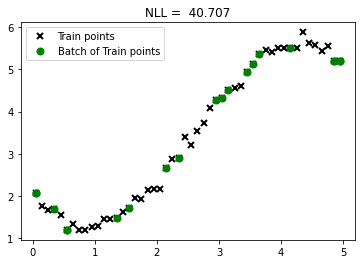

In [11]:
batch_size = 20
idx = np.random.randint(X.shape[0], size=batch_size)
X_subset, Y_subset = X[idx, :], Y[idx]
X_subset, Y_subset

plt.plot(X, Y, "kx", mew=2, label='Train points')

plt.plot(X_subset, Y_subset, "go", mew=2, label='Batch of Train points')

plt.legend()
plt.title("NLL =  %0.3f"  %nll(X_subset, Y_subset, 1, 1, 1))

### Gradient descent using autograd

In [12]:
from autograd import elementwise_grad as egrad
from autograd import grad

In [13]:
grad_objective = grad(nll, argnum=[2, 3, 4])

#### Visualising the objective as a function of iteration

In [14]:
sigma = 2.
l = 2.
noise = 0.5
lr = 1e-2
num_iter = 1500
np.random.seed(0)
nll_arr = np.zeros(num_iter)
for iteration in range(num_iter):
    idx = np.random.randint(X.shape[0], size=batch_size)
    X_subset, Y_subset = X[idx, :], Y[idx]
     
    nll_arr[iteration] = nll(X_subset, Y_subset, sigma, l, noise)
    del_sigma, del_l, del_noise = grad_objective(X_subset, Y_subset, sigma, l, noise)
    sigma = sigma - lr*del_sigma
    l = l - lr*del_l
    noise = noise - lr*del_noise
    
    lr = lr/(iteration+1)

In [15]:
print(sigma**2, l, noise)

4.3561278602353966 1.983897766041748 -0.10206454293334008


Text(0, 0.5, 'NLL')

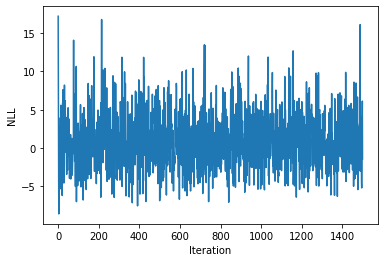

In [16]:
plt.plot(nll_arr)
plt.xlabel("Iteration")
plt.ylabel("NLL")

## Choosing N-Neighbors for SGD batch

In [17]:
sigma = 2.
l = 2.
noise = 0.5
lr = 1e-2
num_iter = 1500
np.random.seed(0)
nll_arr = np.zeros(num_iter)
for iteration in range(num_iter):
    # Sample 1 point
    idx = np.random.randint(X.shape[0], size=1)
    x_val = X[idx]

    K = batch_size 
    a = np.abs(X - x_val).flatten()
    idx = np.argpartition(a,K)[:K] 
    X_subset = X[idx, :]
    Y_subset = Y[idx, :]
     
    nll_arr[iteration] = nll(X_subset, Y_subset, sigma, l, noise)
    del_sigma, del_l, del_noise = grad_objective(X_subset, Y_subset, sigma, l, noise)
    sigma = sigma - lr*del_sigma
    l = l - lr*del_l
    noise = noise - lr*del_noise
    
    lr = lr/(iteration+1)

Text(0, 0.5, 'NLL')

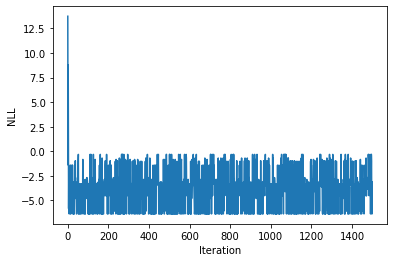

In [18]:
plt.plot(nll_arr)
plt.xlabel("Iteration")
plt.ylabel("NLL")

#### Applying gradient descent and visualising the learnt function

In [19]:
sigma = 2.
l = 2.
noise = 0.5
lr = 1e-2
num_iter = 100
batch_size = 5
nll_arr = np.zeros(num_iter)
fig, ax = plt.subplots()
np.random.seed(0)
for iteration in range(num_iter):
    # Sample 1 point
    idx = np.random.randint(X.shape[0], size=1)
    x_val = X[idx]

    K = batch_size 
    a = np.abs(X - x_val).flatten()
    idx = np.argpartition(a,K)[:K] 
    X_subset = X[idx, :]
    Y_subset = Y[idx, :]
     
    nll_arr[iteration] = nll(X_subset, Y_subset, sigma, l, noise)
    del_sigma, del_l, del_noise = grad_objective(X_subset, Y_subset, sigma, l, noise)
    sigma = sigma - lr*del_sigma
    l = l - lr*del_l
    noise = noise - lr*del_noise
    k.lengthscale = l
    k.variance = sigma**2
    m = GPy.models.GPRegression(X, Y, k, normalizer=False)
    m.Gaussian_noise = noise**2
    m.plot(ax=ax, alpha=0.2)['dataplot'];
    ax.scatter(X_subset, Y_subset, color='green', marker='*', s = 50)
    plt.ylim((0, 6))
    #plt.title(f"Iteration: {iteration:04}, Objective :{nll_arr[iteration]:04.2f}")
    plt.savefig(f"/Users/nipun/Desktop/gp_learning/{iteration:04}.png")
    ax.clear()
    lr = lr/(iteration+1)
plt.clf()

<Figure size 432x288 with 0 Axes>

In [20]:
print(sigma**2, l, noise)

4.239252534833201 2.0031950532157596 0.30136335707188894


In [21]:
!convert -delay 40 -loop 0 /Users/nipun/Desktop/gp_learning/*.png gp-learning-new.gif

![](gp-learning-new.gif)